## Practica para detectar transacciones fraudulentas
### Deep Learning - Autoencoders en Keras

#### Explicacion del dataset

In [14]:
# 1. LECTURA DEL SET DE DATOS
# ===============================================
import pandas as pd
import matplotlib.pyplot as plt

datos = pd.read_csv("creditcard.csv")

nr_clases = datos['Class'].value_counts(sort=True)
print("Tenemos", nr_clases[1], "transacciones fraudulentas")

datos.head()

Tenemos 492 transacciones fraudulentas


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


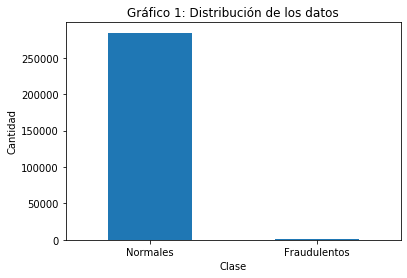

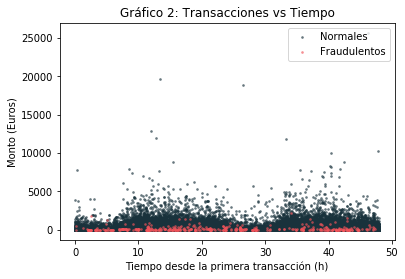

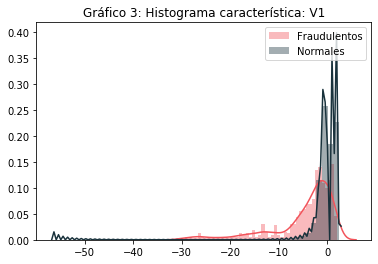

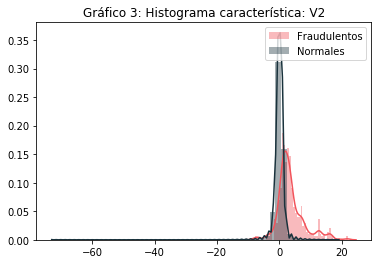

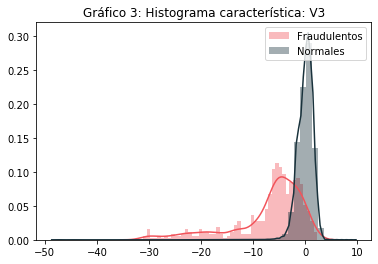

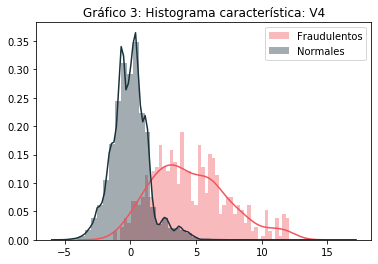

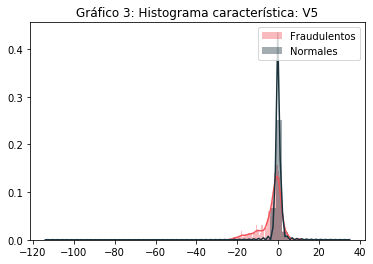

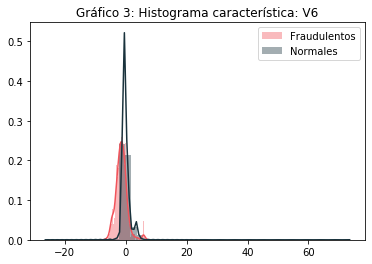

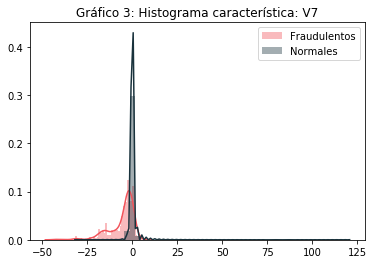

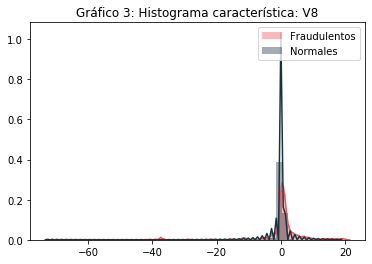

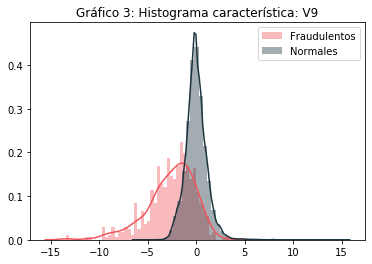

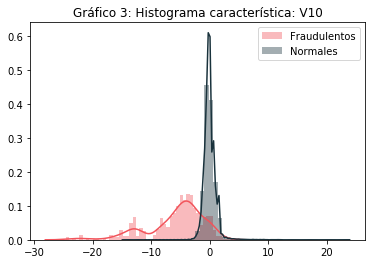

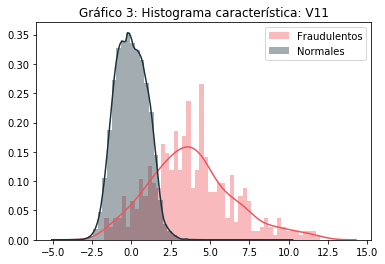

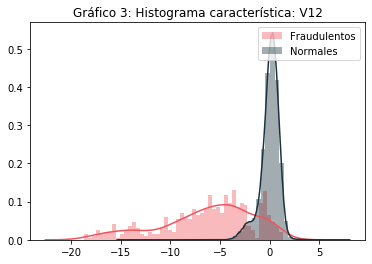

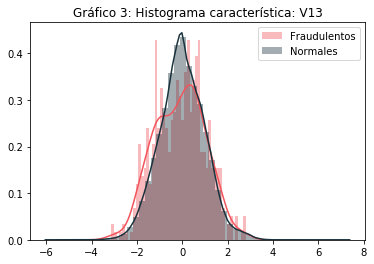

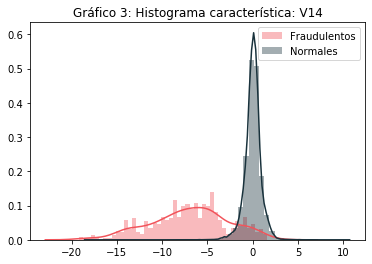

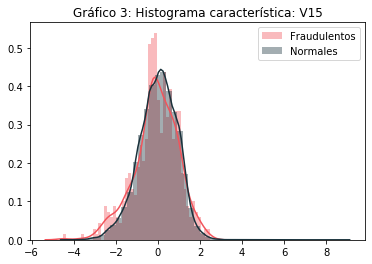

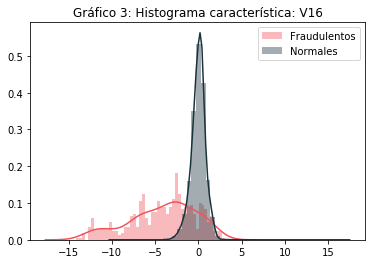

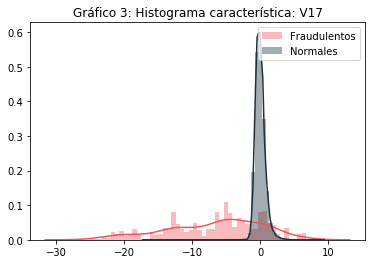

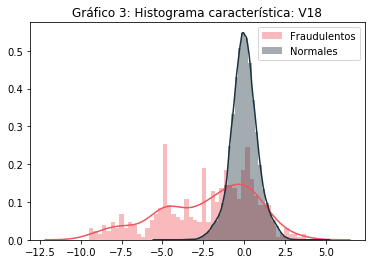

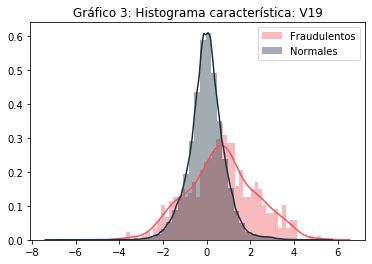

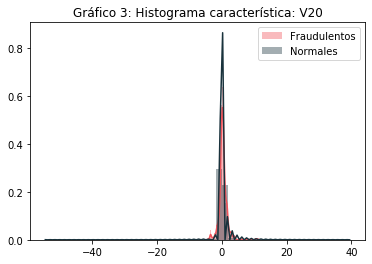

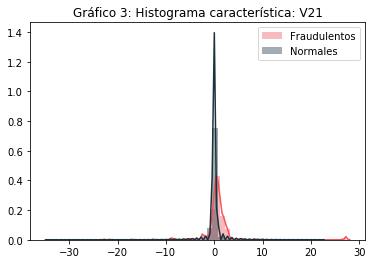

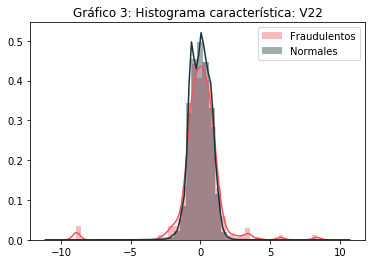

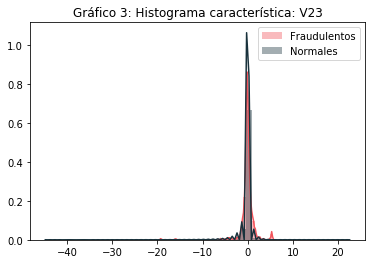

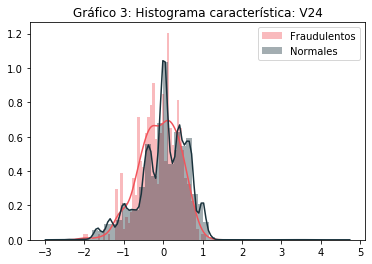

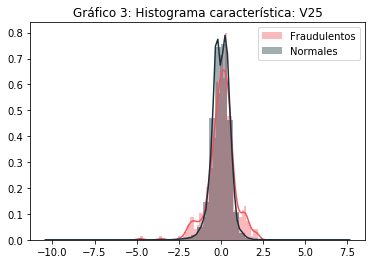

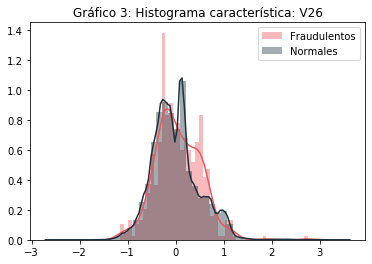

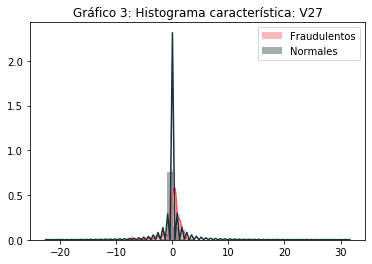

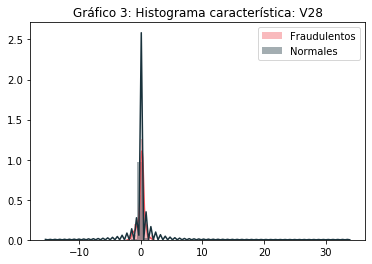

In [18]:
# 2. ANÁLISIS EXPLORATORIO DE LOS DATOS
# ===============================================

# Gráfico 1 - Cantidad de registros normales vs. fraudulentos
nr_clases.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normales', 'Fraudulentos'])
plt.title("Gráfico 1: Distribución de los datos")
plt.xlabel("Clase")
plt.ylabel("Cantidad")
plt.show()

# Gráfico 2 - Transacciones vs Tiempo
normales = datos[datos.Class==0]
fraudulentos = datos[datos.Class==1]
plt.scatter(normales.Time/3600, normales.Amount, 
alpha = 0.5, c='#19323C', label='Normales', s=3)
plt.scatter(fraudulentos.Time/3600, fraudulentos.Amount, 
alpha = 0.5, c='#F2545B', label='Fraudulentos', s=3)
plt.title("Gráfico 2: Transacciones vs Tiempo")
plt.xlabel('Tiempo desde la primera transacción (h)')
plt.ylabel('Monto (Euros)')
plt.legend(loc='upper right')
plt.show()


# Gráfico 3 - Distribución de las características V1 a V28 en normales y fraudulentos
import matplotlib.gridspec as gridspec
import seaborn as sns

v_1_28 = datos.iloc[:,1:29].columns
gs = gridspec.GridSpec(28, 1)
for i, cn in enumerate(datos[v_1_28]):
    sns.distplot(datos[cn][datos.Class == 1], bins=50, 
    label='Fraudulentos', color='#F2545B')
    sns.distplot(datos[cn][datos.Class == 0], bins=50, 
    label='Normales', color='#19323C')
    plt.xlabel('')
    plt.title('Gráfico 3: Histograma característica: ' + str(cn))
    plt.legend(loc='upper right')
    plt.show()

In [19]:
# 3. PRE-PROCESAMIENTO
# ===============================================

# 3.1 La variable "Tiempo" no aporta información. La eliminaremos
from sklearn.preprocessing import StandardScaler
datos.drop(['Time'], axis=1, inplace=True)
datos['Amount'] = StandardScaler().fit_transform(datos['Amount'].values.reshape(-1,1))

from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(datos, test_size=0.2, random_state=42) #
X_train = X_train[X_train.Class == 0]
X_train = X_train.drop(['Class'], axis=1)
X_train = X_train.values

Y_test = X_test['Class']
X_test = X_test.drop(['Class'], axis=1)
X_test = X_test.values

In [20]:
# 4. AUTOENCODER: 29-20-14-20-29, tanh-relu-tanh-relu
# ===================================================
import numpy as np
np.random.seed(5)
from keras.models import Model, load_model
from keras.layers import Input, Dense

dim_entrada = X_train.shape[1]# 29
capa_entrada = Input(shape=(dim_entrada,))

encoder = Dense(20, activation='tanh')(capa_entrada)
encoder = Dense(14, activation='relu')(encoder)

#reconstrucción
decoder = Dense(20, activation='tanh')(encoder)
decoder = Dense(29, activation='relu')(decoder)

autoencoder = Model(inputs=capa_entrada, outputs=decoder)

from keras.optimizers import SGD
sgd = SGD(lr=0.01)
autoencoder.compile(optimizer='sgd', loss='mse')

nits = 100
tam_lote = 32
#asignamos el train tanto a entrada como a salida
autoencoder.fit(X_train, X_train, epochs=nits, batch_size=tam_lote, shuffle=True, validation_data=(X_test,X_test), verbose=1)

Epoch 1/100
7108/7108 [==============================] - 6s 757us/step - loss: 0.9816 - val_loss: 0.8932
Epoch 2/100
7108/7108 [==============================] - 5s 735us/step - loss: 0.8711 - val_loss: 0.8469
Epoch 3/100
7108/7108 [==============================] - 5s 739us/step - loss: 0.8045 - val_loss: 0.8150
Epoch 4/100
7108/7108 [==============================] - 5s 741us/step - loss: 0.7675 - val_loss: 0.7828
Epoch 5/100
7108/7108 [==============================] - 5s 710us/step - loss: 0.7431 - val_loss: 0.7577
Epoch 6/100
7108/7108 [==============================] - 5s 714us/step - loss: 0.7151 - val_loss: 0.7428
Epoch 7/100
7108/7108 [==============================] - 5s 734us/step - loss: 0.7204 - val_loss: 0.7246
Epoch 8/100
7108/7108 [==============================] - 5s 726us/step - loss: 0.6740 - val_loss: 0.7148
Epoch 9/100
7108/7108 [==============================] - 5s 726us/step - loss: 0.6770 - val_loss: 0.7084
Epoch 10/100
7108/7108 [==============================]

7108/7108 [==============================] - 6s 796us/step - loss: 0.6293 - val_loss: 0.6503
Epoch 79/100
7108/7108 [==============================] - 6s 818us/step - loss: 0.6136 - val_loss: 0.6514
Epoch 80/100
7108/7108 [==============================] - 6s 809us/step - loss: 0.6127 - val_loss: 0.6497
Epoch 81/100
7108/7108 [==============================] - 6s 805us/step - loss: 0.6222 - val_loss: 0.6518
Epoch 82/100
7108/7108 [==============================] - 5s 768us/step - loss: 0.6177 - val_loss: 0.6502
Epoch 83/100
7108/7108 [==============================] - 5s 729us/step - loss: 0.6243 - val_loss: 0.6496
Epoch 84/100
7108/7108 [==============================] - 5s 712us/step - loss: 0.6090 - val_loss: 0.6615
Epoch 85/100
7108/7108 [==============================] - 5s 715us/step - loss: 0.6254 - val_loss: 0.6511
Epoch 86/100
7108/7108 [==============================] - 5s 743us/step - loss: 0.6093 - val_loss: 0.6526
Epoch 87/100
7108/7108 [==============================] - 6

In [24]:
# 5. VALIDACIÓN
# ===============================================

# Predicción X_test -> Autoencoder -> X_pred
X_pred = autoencoder.predict(X_test)
ecm = np.mean(np.power(X_test-X_pred,2), axis=1)
print(X_pred.shape)

(56962, 29)


Precision: TP / (TP + FP)

Recall: TP / (TP + FN)

TP: fraude detectado como fraude

FN: fraude detectado como normal

TN: Normal detectado como normal

FP: normal detectado como fraude

Priorizamos el recall mayor

In [ ]:
# Gráfica precision-recall para determinar el umbral
from sklearn.metrics import confusion_matrix, precision_recall_curve
precision, recall, umbral = precision_recall_curve(Y_test, ecm)

plt.plot(umbral, precision[1:], label="Precision",linewidth=5)
plt.plot(umbral, recall[1:], label="Recall",linewidth=5)
plt.title('Precision y Recall para diferentes umbrales')
plt.xlabel('Umbral')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

In [23]:
# 5.3. Matriz de confusión
umbral_fijo = 0.75
Y_pred = [1 if e > umbral_fijo else 0 for e in ecm]

conf_matrix = confusion_matrix(Y_test, Y_pred)
print(conf_matrix)

[[49550  7314]
 [    8    90]]
